## 코호트 분석 : 사용자 행동을 그룹으로 나눠, 지표별로 수치화한 뒤 분석
(특정기간 동안 특정 집단의 행동패턴을 관찰하고 분석)
### 코호트 : 특정 시간에 비슷한 성향을 보이는 그룹


In [433]:
library(tidyverse)
library(lubridate)
library(readxl)
ggplot2::theme_set(theme_bw())

In [3]:
data <- read_xlsx("C:/Soongsil/R/실무 예제/Online Retail.xlsx")

In [4]:
data1 <- data %>% mutate(InvoiceDate = lubridate::as_datetime(InvoiceDate))
data1 %>% head(2)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>
536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


**중복행 제거**

In [5]:
nrow(data1) # 전체 데이터 행 수
nrow(unique(data1)) # 중복되지 않은 행 수

[1] 541909

[1] 536641

In [6]:
data2 <- data1[which(duplicated(data1) == FALSE), ]

In [7]:
nrow(data2)
nrow(unique(data2))

[1] 536641

[1] 536641

**결측값 확인**

In [8]:
sum(is.na(data2))

[1] 136491

In [9]:
data3 <- na.omit(data2)
nrow(data3)

[1] 401604

### 
### 데이터 조작 & 코호트 생성
(예를 들어, 온라인데이터에서 제공되는 날짜변수를 통해 월별/주별/분기별/년별 등으로 고객들을 세분화 시키는 분석법)

**2011년 데이터만 추출**

In [10]:
data4 <- data3 %>% mutate(InvoiceYear = year(InvoiceDate)) %>%
    filter(InvoiceYear == 2011)
data4 %>% nrow

[1] 375250

**A. 각 ID별 구매 횟수**

In [11]:
order.frequency <- data4 %>% group_by(CustomerID) %>% count() 
order.frequency %>% head(2)

CustomerID,n
<dbl>,<int>
12346,2
12347,151


**B. 각 ID별 최초 구매일**

In [12]:
Join_date <- data4 %>% group_by(CustomerID) %>% summarise(Join_Date = min(InvoiceDate))
Join_date %>% head(2)

CustomerID,Join_Date
<dbl>,<dttm>
12346,2011-01-18 10:01:00
12347,2011-01-26 14:30:00


**C. 초기 데이터와 B 병합 (초기 데이터에 각 ID별 최초 구매일 변수 추가)**

In [13]:
cohorts <- data4 %>% left_join(Join_date, by = "CustomerID")
cohorts %>% tail(1)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear,Join_Date
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>,<dbl>,<dttm>
581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,France,2011,2011-08-18 15:44:00


### 최초 구매일의 월 단위로 코호트 지정
**D. 각 ID별 최초 구매일의 월 변수 추출 => 코호트 변수 (Cohort) 생성**

In [14]:
cohorts2 <- cohorts %>% mutate(Cohort = month(Join_Date))
cohorts2 %>% head(1)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear,Join_Date,Cohort
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>,<dbl>,<dttm>,<dbl>
539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313,United Kingdom,2011,2011-01-04 10:00:00,1


### 

### 가입 날짜 (Join_Date) 와 구매 날짜 (InvoiceDate)의 차이를 구해서, 활동하는 고객에 대한 코호트 설정

**InvoiceDate와 Join_Date의 날짜 차이를 뜻하는 Days변수 생성**

In [15]:
cohorts3 <- cohorts2 %>% mutate(Days = as_date(InvoiceDate) - as_date(Join_Date))
cohorts3 %>% tail(1)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear,Join_Date,Cohort,Days
<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<dbl>,<chr>,<dbl>,<dttm>,<dbl>,<drtn>
581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680,France,2011,2011-08-18 15:44:00,8,113 days


**Months = Days / 30 (월 단위로 변경)**

**InvoiceDate과 Join_Date의 포맷을 "%Y-%m"으로 변경**

In [16]:
cohorts3 %>% mutate(Months = round(as.numeric(Days) / 30),
                    InvoiceDate = format(InvoiceDate, "%Y-%m"),
                    Join_Date = format(Join_Date, "%Y-%m")) -> cohorts4
cohorts4 %>% tail(1)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear,Join_Date,Cohort,Days,Months
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<drtn>,<dbl>
581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12,4.95,12680,France,2011,2011-08,8,113 days,4


### 
### 코호트 생성

**코호트변수 Cohort를 순서형변수로 변환하고, 변수 범주를 '월'이름으로 변경**

**가입날짜와 구매날짜의 차이를 30으로 나눈 변수 Months를 순서형 변수로 변환**

In [59]:
groups <- c("Jan Cohort", "Feb Cohort", "Mar Cohort", "Apr Cohort", "May Cohort", "Jun Cohort",
            "Jul Cohort", "Aug Cohort", "Sep Cohort", "Oct Cohort", "Nov Cohort", "Dec Cohort")

In [73]:
cohorts5 <- cohorts4 %>% 
    mutate(Cohort = factor(Cohort, ordered = TRUE,
                           levels = c("1", "2", "3", "4", "5", "6",
                                                            "7", "8", "9", "10", "11", "12"))) %>%
    mutate(Months = factor(Months, ordered = TRUE,
                          levels = c("0", "1", "2", "3", "4", "5",
                                     "6", "7", "8", "9", "10", "11")))

In [74]:
levels(cohorts5$Cohort) <- groups

In [75]:
cohorts5 %>% head(1)

InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYear,Join_Date,Cohort,Days,Months
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<ord>,<drtn>,<ord>
539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01,1.95,13313,United Kingdom,2011,2011-01,Jan Cohort,0 days,0


### 
### Rolling Retention : 특정시점을 기준으로, 기간 후에 얼마나 고객이 남아있는지 확인하는 지표
### 시각화

**최초 구매월(코호트 변수), Month(최초 구입과 최근 구매와의 일자 차이)고객 수 누적표**

In [151]:
cohorts5 %>% group_by(Cohort, Months) %>% 
    summarise(n = n_distinct(CustomerID)) %>% 
    spread(Months, n)

`summarise()` has grouped output by 'Cohort'. You can override using the `.groups` argument.


Cohort,0,1,2,3,4,5,6,7,8,9,10,11
<ord>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Jan Cohort,783,307,343,306,349,328,314,298,342,337,414,244
Feb Cohort,499,123,148,155,156,126,160,160,168,169,98,NA
Mar Cohort,530,110,135,123,132,101,132,142,156,79,NA,NA
Apr Cohort,360,86,97,75,82,76,95,100,62,NA,NA,NA
May Cohort,317,65,56,57,70,77,87,52,NA,NA,NA,NA
Jun Cohort,263,55,47,59,66,90,31,NA,NA,NA,NA,NA
Jul Cohort,218,46,40,58,57,31,NA,NA,NA,NA,NA,NA
Aug Cohort,184,46,51,51,23,NA,NA,NA,NA,NA,NA,NA
Sep Cohort,313,86,104,30,NA,NA,NA,NA,NA,NA,NA,NA


`summarise()` has grouped output by 'Cohort'. You can override using the `.groups` argument.


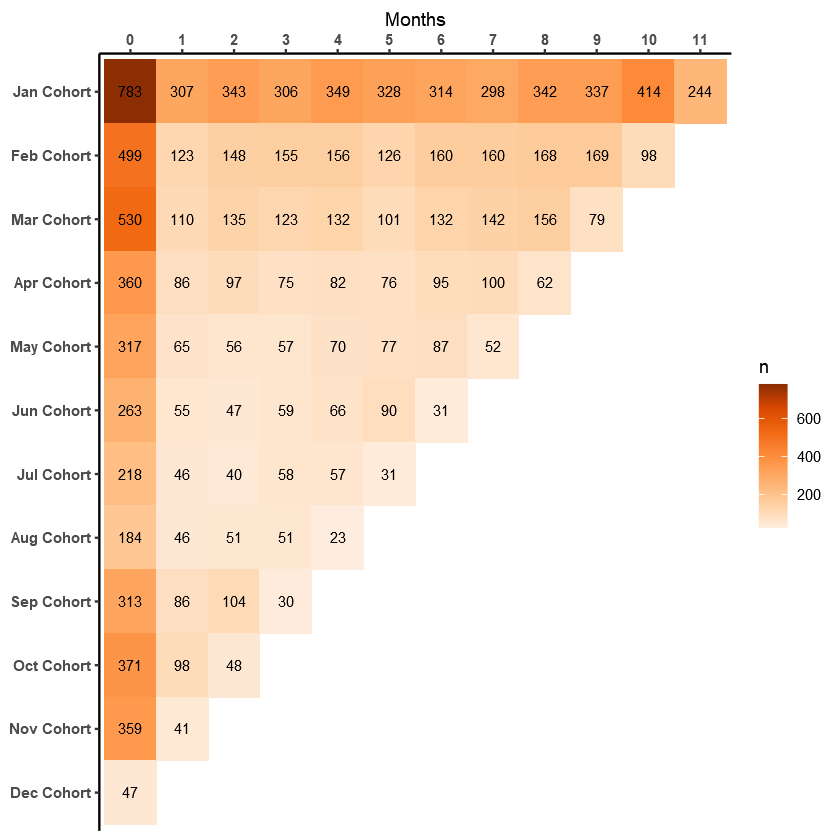

In [154]:
cohorts5 %>% group_by(Cohort, Months) %>% 
    summarise(n = n_distinct(CustomerID)) %>% 
    ggplot(aes(Months, fct_relevel(Cohort, rev(levels(cohorts5$Cohort))), fill = n)) + 
    geom_tile() +
    scale_x_discrete(position = "top") +
    geom_text(aes(label = n), size = 3) +    
    theme(axis.title.y = element_blank(),
          axis.text = element_text(face = "bold")) + 
    scale_fill_distiller(palette = "Oranges", direction = 1)

- **히트맵의 제일 좌측 열은 해당 월(코호트)의 신규 가입자**
- **1월에 신규 가입자가 제일 많음, 12월로 갈 수록 신규 가입자가 감소 (세로축)**
- **1월의 신규 가입자 중, 11개월 뒤에도 물건을 구매한 가입자는 244명**

### 
### Retention Rate : 신규가입자가 남아있을 확률

- **월 별 신규 구매자 수**

In [236]:
new <- cohorts5 %>% group_by(Cohort) %>% 
    summarise(new = n_distinct(CustomerID)) 
new %>% head(3)

Cohort,new
<ord>,<int>
Jan Cohort,783
Feb Cohort,499
Mar Cohort,530


**코호트별 Retention Rate**

`summarise()` has grouped output by 'Cohort'. You can override using the `.groups` argument.


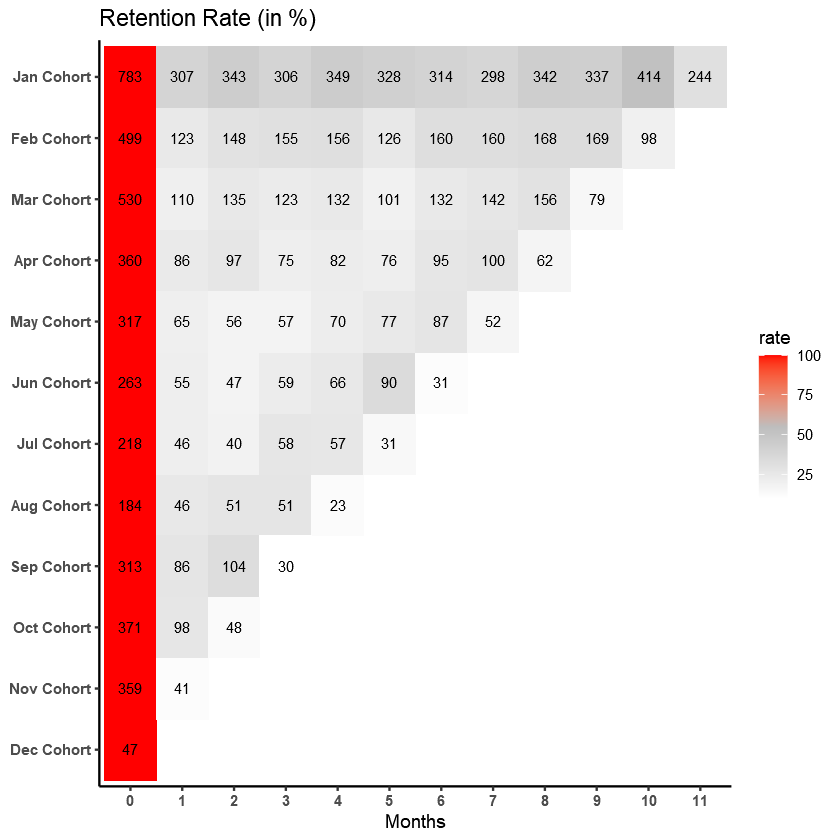

In [187]:
cohorts5 %>% group_by(Cohort, Months) %>% 
    summarise(n = n_distinct(CustomerID)) %>%   
    merge(new, by = "Cohort") %>%
    mutate(rate = round(n / new * 100, 3)) %>% 
    ggplot(aes(Months, fct_relevel(Cohort, rev(levels(cohorts5$Cohort))), fill = rate)) + 
    geom_tile() +
    geom_text(aes(label = n), size = 3) +    
    theme(axis.title.y = element_blank(),
          axis.text = element_text(face = "bold")) + 
    scale_fill_gradientn(
        colours = c("White", "gray", "red"),
        na.value = "White") + 
    ggtitle("Retention Rate (in %)")

**코호트별 평균 구매 수량**

`summarise()` has grouped output by 'Cohort'. You can override using the `.groups` argument.


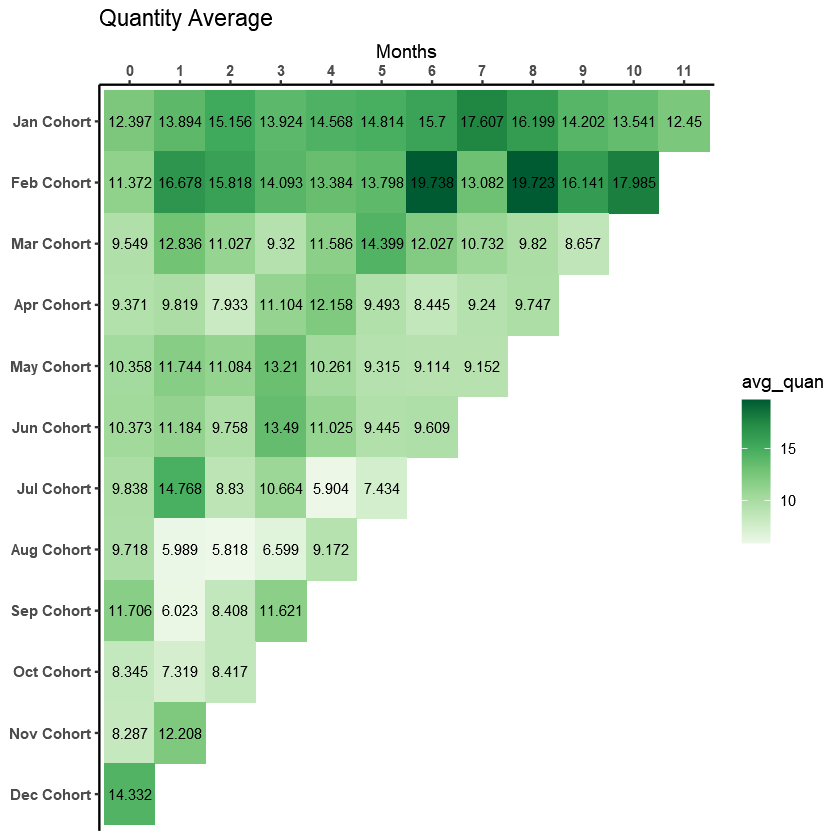

In [237]:
cohorts5 %>% group_by(Cohort, Months) %>% 
    summarise(avg_quan = mean(Quantity)) %>%
    ggplot(aes(Months, fct_relevel(Cohort, rev(levels(cohorts5$Cohort))), fill = avg_quan)) + 
    geom_tile() +
    scale_x_discrete(position = "top") +
    geom_text(aes(label = round(avg_quan, 3)), size = 3) +    
    theme(axis.title.y = element_blank(),
          axis.text = element_text(face = "bold")) + 
    scale_fill_distiller(palette = "Greens", direction = 1) + 
    ggtitle("Quantity Average")

### 
# 
## RFM with Modeling
- R (Recent): 최근 / F (Frequency): 자주 / M (Monetary): 통화량

**구매 금액 (Purchase) = 구매수량 (Quantity)$\times$ 가격 (UnitPrice)**

In [199]:
retail_merge %>%
    mutate(Purchase = (Quantity * UnitPrice)) -> rfm
rfm %>% head(1)

,CustomerID,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,InvoiceMonth,Month,Purchase
,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dttm>,<dbl>,<chr>,<dttm>,<dttm>,<dbl>
1,12346,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,United Kingdom,2011-01-01,2011-01-01,77183.6


### 
**snapshot_date (분석 기준 날짜): 데이터상 최근 구매 일자 + 1**

In [202]:
snapshot_date <- max(rfm$InvoiceDate) + days(1); snapshot_date

[1] "2011-12-10 12:50:00 UTC"

**데이터상 최초 구매 일자**

In [203]:
min(rfm$InvoiceDate)

[1] "2010-12-01 08:26:00 UTC"

### 
### R : 분석 기준 날짜 - 고객별 데이터상 최근 구매 일자

**고객별 최근 구매 일자**

In [233]:
rfm %>% group_by(CustomerID) %>%
    summarise(Recent_date = max(InvoiceDate)) -> Recent
Recent %>% head(1)

CustomerID,Recent_date
<dbl>,<dttm>
12346,2011-01-18 10:01:00


**분석 기준 일자와, 고객별 최근 구매 일자의 차이 => 고객별 가장 최근 구매 날짜로 부터 지난 기간**

In [234]:
Recent %>% mutate(Recent = round(as.numeric(snapshot_date - Recent_date), 0)) -> Recent1
Recent1 %>% head(1)

CustomerID,Recent_date,Recent
<dbl>,<dttm>,<dbl>
12346,2011-01-18 10:01:00,326


### 
### F : 고객별 구매 횟수

In [230]:
rfm %>% group_by(CustomerID) %>% 
    summarise(Frequency = n()) -> Frequency
Frequency %>% head(1)

CustomerID,Frequency
<dbl>,<int>
12346,1


### 
### M : 고객별 누적 구매 금액

In [226]:
rfm %>% group_by(CustomerID) %>%
    summarise(Monetary = sum(Purchase)) -> Monetary
Monetary %>% head(1)

CustomerID,Monetary
<dbl>,<dbl>
12346,77183.6


### 
### RFM 병합

In [239]:
Recent1 %>% merge(Frequency, by = "CustomerID") %>% merge(Monetary, by = "CustomerID")  -> RFM
RFM %>% head(3)

,CustomerID,Recent_date,Recent,Frequency,Monetary
,<dbl>,<dttm>,<dbl>,<int>,<dbl>
1,12346,2011-01-18 10:01:00,326,1,77183.60
2,12347,2011-12-07 15:52:00,3,182,4310.00
3,12348,2011-09-25 13:13:00,76,31,1797.24


### 
### RFM을 통한 고객 분류

### ```ntile(data, n)``` : data를 n 분위로 나누고, 데이터 별 분위수 계산
- data의 값이 높을수록 높은 분위수 반환 (오름차순)

### 


**Recent는 낮을수록 높은 점수 / Frequency와 Monetary는 높을수록 높은 점수**

**각 점수의 총합 => RFM_score**

In [241]:
RFM %>% 
    mutate(R = ntile(-Recent, 4), 
           Fr = ntile(Frequency, 4),
           M = ntile(Monetary, 4),
           RFM_score = R + Fr + M) -> RFM1
RFM1 %>% head(3)

,CustomerID,Recent_date,Recent,Frequency,Monetary,R,Fr,M,RFM_score
,<dbl>,<dttm>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,12346,2011-01-18 10:01:00,326,1,77183.60,1,1,4,6
2,12347,2011-12-07 15:52:00,3,182,4310.00,4,4,4,12
3,12348,2011-09-25 13:13:00,76,31,1797.24,2,2,4,8


### 
### 세그먼트(Segment) 생성 : RFM_score로, 고객의 등급을 Gold / Silver / Bronze로 구분
- RFM_score의 상위 25%를 Gold / 상위 50%를 Silver / 나머지 Bronze

In [252]:
quantile(RFM1$RFM_score, 0.75)
quantile(RFM1$RFM_score, 0.5)

75% 
 10

50% 
  7

In [253]:
RFM1 %>% mutate(Segment = ifelse(RFM_score > 10, "Gold",
                                  ifelse(RFM_score > 7, "Silver", "Bronze"))) -> RFM2
RFM2 %>% head(3)

,CustomerID,Recent_date,Recent,Frequency,Monetary,R,Fr,M,RFM_score,Segment
,<dbl>,<dttm>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,<chr>
1,12346,2011-01-18 10:01:00,326,1,77183.60,1,1,4,6,Bronze
2,12347,2011-12-07 15:52:00,3,182,4310.00,4,4,4,12,Gold
3,12348,2011-09-25 13:13:00,76,31,1797.24,2,2,4,8,Silver


**각 Segment별 평균**

In [255]:
RFM2 %>% group_by(Segment) %>% summarise(Recent_avg = mean(Recent),
                                          Frequency_avg = mean(Frequency),
                                          Monetary_avg = mean(Monetary),
                                          RFM_score_avg = mean(RFM_score)) -> RFM_seg
RFM_seg

Segment,Recent_avg,Frequency_avg,Monetary_avg,RFM_score_avg
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Bronze,149.36620,22.45116,482.8572,5.103135
Gold,14.15024,285.18750,6897.7626,11.527644
Silver,48.40153,81.22682,1598.0856,8.970115


### 
### K-Means Clustering

**Recent, Frequency, Monetary 변수에 표준화**

In [258]:
RFM2 %>% select(c("Recent", "Frequency", "Monetary")) %>% scale() -> RFM_scale

**거리행렬**

In [262]:
library(factoextra)

In [263]:
RFM_dist <- dist(RFM_scale)

### **최적의 군집수 탐색**

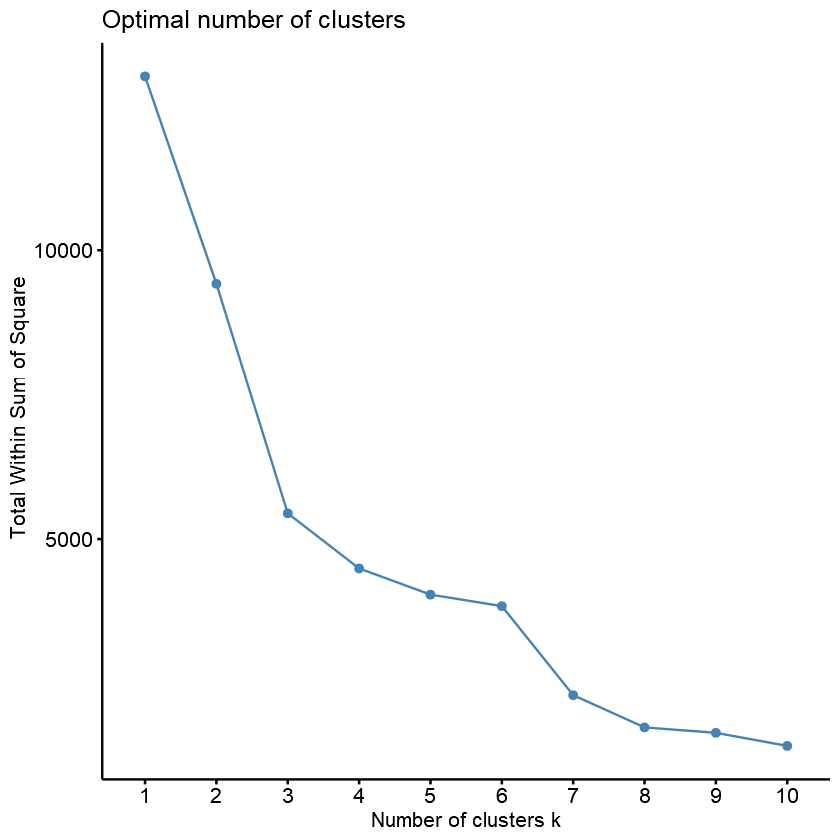

In [267]:
fviz_nbclust(RFM_scale, FUN = kmeans, method = "wss", k.max = 10)
# fviz_nbclust(RFM_scale, FUN = kmeans, method = "silhouette", k.max = 10)

### 
### K = 3의 군집분석 실시 및 시각화

**주성분분석(PCA)에 의해 생성된 성분간의 관계를 표현**

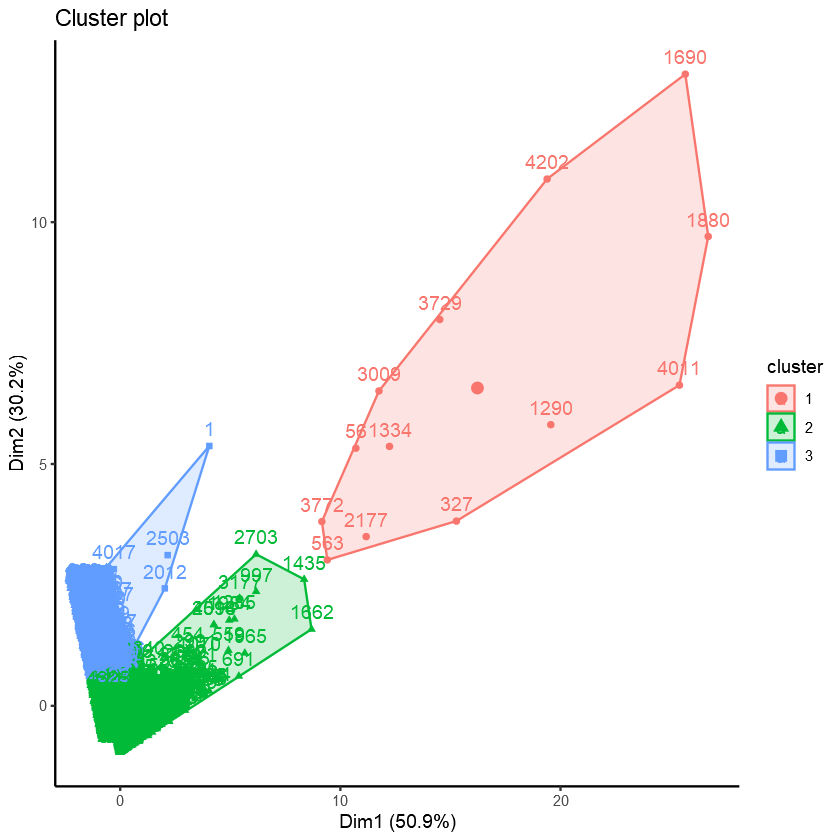

In [270]:
k3 <- kmeans(RFM_scale, 3)
fviz_cluster(k3, data = RFM_scale) + theme_classic()

**각 주성분들에 대한 정보**
- **주성분1에는 Frequency, Monetary가 높은 기여도를 가짐**
- **주성분2에는 Recent가 높은 기여도를 가짐**

In [273]:
library(FactoMineR)

In [276]:
pca <- PCA(RFM_scale, graph = FALSE)
a <- fviz_contrib(pca, choice = "var", axes = 1) + theme_classic()
b <- fviz_contrib(pca, choice = "var", axes = 2) + theme_classic()

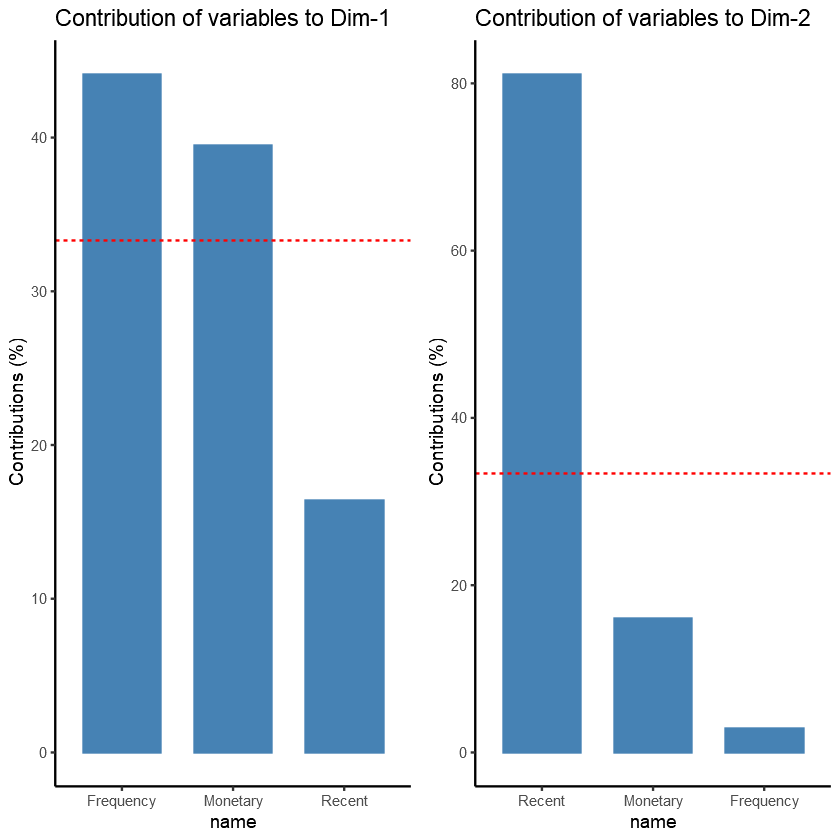

In [281]:
library(gridExtra)
gridExtra::grid.arrange(a, b, nrow = 1)

### 군집의 응집도

In [287]:
library(cluster)

- "실루엣 값이 1에 가까우면 다른 군집과의 거리보다 동일 군집 내 객체 간 거리가 가깝다는 뜻이므로, 객체 i가 잘 군집화가 되었다는 의미"
- 만약 대부분의 객체가 높은 실루엣 값을 가진다면 군집의 구성이 적절하게 잘 되었다고 평가. 
- 반면 많은 객체들이 낮거나 혹은 음(-)의 실루엣 값을 가진다면 군집 구성이 너무 많거나 또는 너무 적은 수의 군집을 가졌기 때문이라고 판단

**군집간 평균 실루엣 계수**

  cluster size ave.sil.width
1       1   13          0.09
2       2 3244          0.61
3       3 1081          0.59


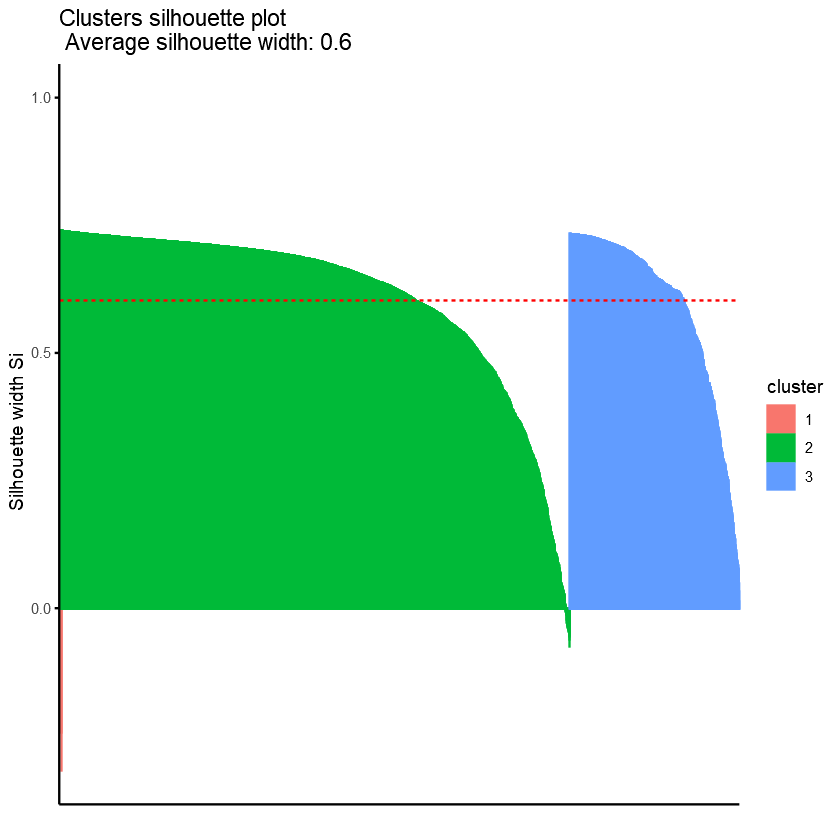

In [309]:
sil <- cluster::silhouette(k3$cluster, RFM_dist) 
fviz_silhouette(sil)

**실루엣 계수평균**

In [310]:
mean(sil %>% data.frame() %>% .$sil_width)

[1] 0.602097

**군집의 응집도**

In [304]:
k3$tot.withinss

[1] 5444.785

**설명된 분산의 비율 = 군집간 분산 / 전체 분산**

In [305]:
k3$betweenss / k3$totss

[1] 0.5815245

### 
### 군집별 정보

**군집 라벨링, 군집별 Recent, Frequency, Monetary의 평균값**

In [316]:
RFM2 %>% mutate(Cluster = k3$cluster) -> RFM3

In [357]:
RFM3 %>% mutate(Cluster = factor(Cluster)) %>%
    group_by(Cluster) %>% 
    summarise(Recent_avg = mean(Recent), 
              Frequency_avg = mean(Frequency), 
              Monetary_avg = mean(Monetary),
              RFM_score_avg = mean(RFM_score)) -> cluster_mean
cluster_mean

Cluster,Recent_avg,Frequency_avg,Monetary_avg,RFM_score_avg
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,5.00000,2535.92308,125981.3400,11.692308
2,41.87608,101.76757,2023.3204,8.483354
3,247.71600,27.37373,634.4126,4.493062


In [410]:
cluster_mean %>% gather(key = "Cluster", value = "value") %>%
    mutate(Clusters = rep(cluster_mean$Cluster, 4))

Cluster,value,Clusters
<chr>,<dbl>,<fct>
Recent_avg,5.000000e+00,1
Recent_avg,4.187608e+01,2
Recent_avg,2.477160e+02,3
Frequency_avg,2.535923e+03,1
Frequency_avg,1.017676e+02,2
Frequency_avg,2.737373e+01,3
Monetary_avg,1.259813e+05,1
Monetary_avg,2.023320e+03,2
Monetary_avg,6.344126e+02,3


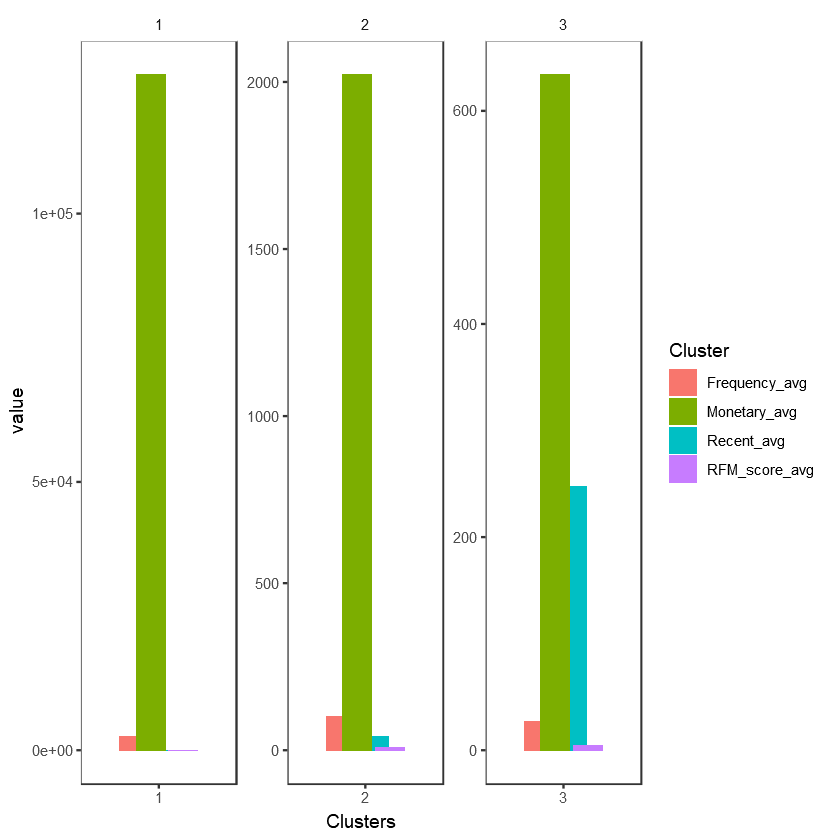

In [435]:
cluster_mean %>% gather(key = "Cluster", value = "value") %>%
    mutate(Clusters = rep(cluster_mean$Cluster, 4)) %>%
    ggplot(aes(x = Clusters, y = value, fill = Cluster)) + 
    geom_bar(position = position_dodge(0.5), stat = "identity") + 
    facet_wrap(~ Clusters, scales = "free") + 
    theme(strip.background = element_rect(colour = "white", fill = "white"),
          panel.grid = element_blank()) 